In [1]:
import numpy as np
import pandas as pd
from sklearn import datasets
import matplotlib.pyplot as plt

import tensorflow as tf
import os
import PIL
from tensorflow.keras import layers
from tensorflow import keras
from keras import losses
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, GaussianNoise,Conv1DTranspose,Conv2DTranspose, ReLU
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers import MaxPooling2D
from keras.layers import Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D,Conv1D
from keras.models import Sequential, Model
import keras.backend as K
import time

from IPython import display
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd /content/drive/MyDrive/independent_project/

## Load data

In [ ]:
data = pd.read_csv('dataset/pollution_10_1.csv')

In [ ]:
# data.head()
data.tail()

,minute,PM10 [ug m-3],PM2.5 [ug m-3],PM1 [ug m-3],CO2 [ppm],T [F],RH [%]
1414,1424,62.5,42.9,21.5,458,65.3,54.4
1415,1425,22.2,17.4,8.9,444,65.1,52.0
1416,1426,34.8,25.4,12.2,442,64.4,51.8
1417,1427,76.0,57.2,28.4,450,64.8,53.7
1418,1428,56.7,39.8,19.4,456,66.4,53.2


In [ ]:
X_train = data.to_numpy()

In [ ]:
print(X_train.shape)

(1419, 7)


In [ ]:
codings_size = X_train.shape[1]

In [ ]:
group = ['PM10 [ug m-3]',	'PM2.5 [ug m-3]',	'PM1 [ug m-3]',	'CO2 [ppm]',	'T [F]',	'RH [%]']

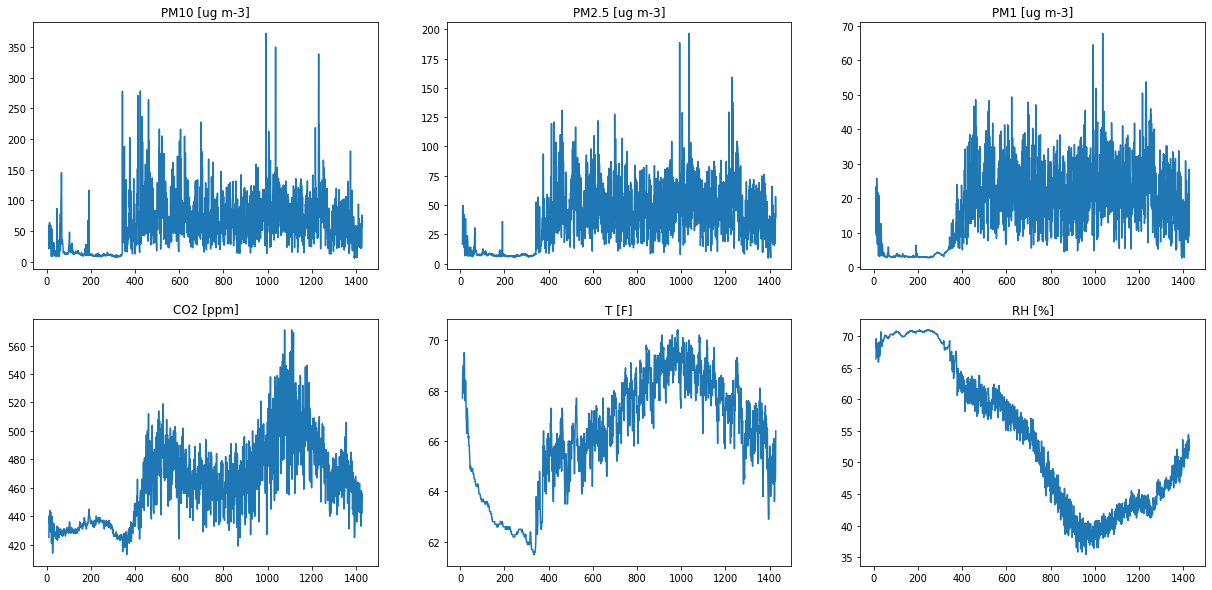

In [ ]:
fig, ax = plt.subplots(2,3, figsize=[21,10])
for i in range(6):
    ax.flatten()[i].plot(X_train[:,0], X_train[:,i+1])
    ax.flatten()[i].set_title(group[i])

In [ ]:
scaler = MinMaxScaler((-1,1))
X_train_scaled = scaler.fit_transform(X_train)
np.allclose(X_train, scaler.inverse_transform(X_train_scaled))

True

In [ ]:

def concat_timesteps(X_train, ntimes, step):
    X_train_concat = []
    for i in range(0, len(X_train)-ntimes*step):
        X_train_concat.append(X_train[i:i+ntimes*step:step])
    return np.array(X_train_concat)

In [ ]:
ntimes = 10 # Consecutive times for the GAN
step = 1 # step between times

X_train_concat = concat_timesteps(X_train_scaled, ntimes, step)

(1409, 10, 7)


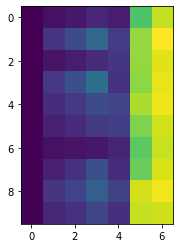

In [ ]:

print(X_train_concat.shape)
plt.imshow(X_train_concat[0, :, :])

In [ ]:
BATCH_SIZE = 128
latent_space = 50

# Create a tensorflow dataset and split it into batches
train_dataset = X_train_concat.reshape(X_train_concat.shape[0], ntimes, codings_size , 1).astype('float32')
train_dataset = train_dataset[:-1,:,:,:]
train_dataset = tf.data.Dataset.from_tensor_slices(train_dataset)
train_dataset = train_dataset.shuffle(len(X_train_concat))
train_dataset = train_dataset.batch(BATCH_SIZE)
# for data in train_dataset:
#     print(data)
#     break

In [ ]:
def sample_z(args):
    mu, log_var = args
    batch = K.shape(mu)[0]
    eps = K.random_normal(shape=(batch, latent_space), mean=0., stddev=1.)
    return mu + K.exp(log_var / 2) * eps

# Architecture

In [ ]:
def build_encoder():
    input_enc = Input(shape=(10,7,1))

    enc = Conv2D(64, kernel_size=(5,5), strides=(2,2), padding='same', use_bias=False)(input_enc)
    enc = BatchNormalization()(enc)
    enc = LeakyReLU()(enc) 
    
    enc = Conv2D(128, kernel_size=(3,3), strides=(1,2), padding='same', use_bias=False)(input_enc)
    enc = BatchNormalization()(enc)
    enc = LeakyReLU()(enc) 

    enc = Flatten()(enc)
  
    mu = Dense(latent_space, use_bias=False, activation = 'tanh' )(enc) 
    sigma = Dense(latent_space, use_bias=False, activation = 'tanh' )(enc)

    latent_repr = Lambda(sample_z)([mu, sigma])
    generator_encoder = Model(input_enc, latent_repr, name='Encoder')
    
    return generator_encoder

In [ ]:
def build_decoder():
    input_dec = Input(shape=(latent_space,))

    dec = Dense(5*4*256, use_bias=False)(input_dec)
    dec = BatchNormalization()(dec)
    dec = LeakyReLU()(dec)
    dec = Reshape((5, 4, 256))(dec)

    dec = Conv2DTranspose(128, kernel_size=(3, 3), strides=(1, 1), padding='same', use_bias=False)(dec)
    dec = BatchNormalization()(dec)
    dec = LeakyReLU()(dec)

    dec = Conv2DTranspose(64, kernel_size=(3, 3), strides=(1, 1), padding='same', output_padding=[0,0], use_bias=False)(dec)
    dec = BatchNormalization()(dec)
    dec = LeakyReLU()(dec)

    output_dec = Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', output_padding=[1,0], use_bias=False, activation='tanh') (dec)

    generator_decoder = Model(input_dec, output_dec, name='Decoder')

    return generator_decoder

In [ ]:
def build_discriminator():
    in_disc = Input(shape=(latent_space))
    
    disc = Dense(64, use_bias=False)(in_disc) 
    disc = BatchNormalization()(disc)
    disc = LeakyReLU()(disc)

    disc = Dense(128, use_bias=False)(in_disc) 
    disc = BatchNormalization()(disc)
    disc = LeakyReLU()(disc)

    disc = Flatten()(disc)
    disc_output = Dense(1, activation='sigmoid')(disc)

    discriminator = Model(in_disc, disc_output, name='Discriminator')

    return discriminator

In [ ]:
# Build the encoder / decoder
encoder = build_encoder()
decoder = build_decoder()

# Build the discriminator
optimizer = tf.optimizers.Adam(1e-4)
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
discriminator.trainable = False

In [ ]:
np.random.seed(32)
tf.random.set_seed(32)

In [ ]:
# The generator takes the image, encodes it and reconstructs it
# from the encoding
real_input = Input(shape=(10,7,1))
encoder_output = encoder(real_input)
decoder_output = decoder(encoder_output)

# The discriminator determines validity of the encoding
validity = discriminator(encoder_output)

# The adversarial_autoencoder model  (stacked generator and discriminator)
adversarial_autoencoder = Model(real_input, [decoder_output, validity], name='AAE')
adversarial_autoencoder.compile(loss=['mse', 'binary_crossentropy'], loss_weights=[0.999, 0.01], optimizer=optimizer)

# Train

In [ ]:
epoch = 5000

In [ ]:
# # Adversarial ground truths
# real = np.ones((BATCH_SIZE, 1))
# fake = np.zeros((BATCH_SIZE, 1))

In [ ]:
def train(dataset, epochs):

    # Training the model
    for epoch in range(epochs):
        # c1_tmp, c2_tmp, g1_tmp = list(), list(), list()
        
        for batch in dataset:
            
            if batch.shape[0]==BATCH_SIZE:
                latent_real = tf.random.normal([BATCH_SIZE, latent_space])
                real = np.ones(BATCH_SIZE)
                fake = np.zeros(BATCH_SIZE)

            else:
                latent_real = tf.random.normal([batch.shape[0]%BATCH_SIZE, latent_space])
                latent_real = latent_real.numpy()
                latent_real = latent_real.astype('float32')

                real = np.ones(batch.shape[0]%BATCH_SIZE)
                fake = np.zeros(batch.shape[0]%BATCH_SIZE)

            latent_fake = encoder.predict(batch)

            d_loss_real = discriminator.train_on_batch(latent_real, real)

            d_loss_fake = discriminator.train_on_batch(latent_fake, fake)
 
            g_loss = adversarial_autoencoder.train_on_batch(batch, [batch, real])

        # if epoch % 100 == 0:
        #     num_examples_to_generate = 100

        #     seed = tf.random.normal([num_examples_to_generate, latent_space])
        #     X_generated = scaler.inverse_transform(decoder.predict(seed).reshape(num_examples_to_generate*ntimes,codings_size))

        #     columnIndex = 0
        #     # Sort 2D numpy array by 1st Column
        #     X_generated = X_generated[X_generated[:,columnIndex].argsort()]

        #     fig, ax = plt.subplots(2,3, figsize=[21,10])
        #     for i in range(6):
        #         ax.flatten()[i].plot(X_train[:,0], X_train[:,i+1])
        #         ax.flatten()[i].plot(X_generated[:,0], X_generated[:,i+1], '.')
        #         ax.flatten()[i].legend(['Real Data','GAN'])
        #         ax.flatten()[i].set_title(group[i])
 
            
        print("%d " % (epoch+1))



In [ ]:
hist = train(train_dataset, epochs=epoch)

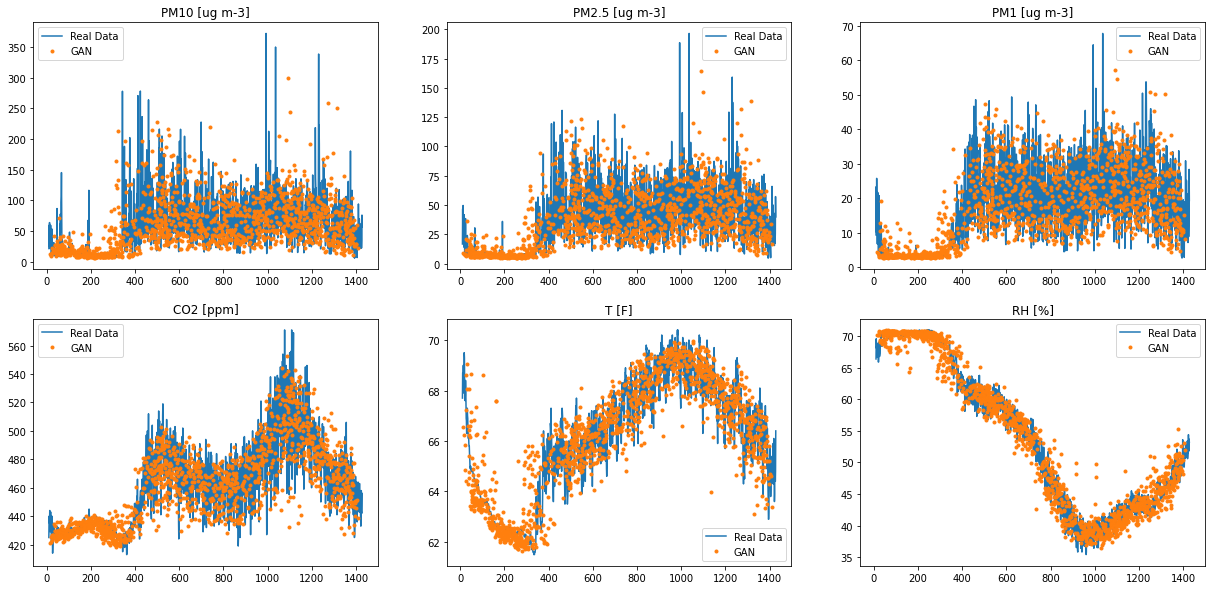

In [ ]:
num_examples_to_generate = 150

seed = tf.random.normal([num_examples_to_generate, latent_space])
X_generated = scaler.inverse_transform(decoder.predict(encoder(X_train_concat)).reshape(-1,codings_size))

columnIndex = 0
# Sort 2D numpy array by 1st Column
X_generated = X_generated[X_generated[:,columnIndex].argsort()]

fig, ax = plt.subplots(2,3, figsize=[21,10])
for i in range(6):
    ax.flatten()[i].plot(X_train[:,0], X_train[:,i+1])
    ax.flatten()[i].plot(X_generated[::10,0], X_generated[::10,i+1], '.')
    ax.flatten()[i].legend(['Real Data','GAN'])
    ax.flatten()[i].set_title(group[i])

In [ ]:
encoder.save('./pollution_aae_7d_model/encoder_'+str(epoch)+'_'+str(latent_space))
decoder.save('./pollution_aae_7d_model/decoder_'+str(epoch)+'_'+str(latent_space))
discriminator.save('./pollution_aae_7d_model/discriminator_'+str(epoch)+'_'+str(latent_space))
print('save model')

INFO:tensorflow:Assets written to: ./pollution_aae_7d_model/encoder_5000_50/assets
INFO:tensorflow:Assets written to: ./pollution_aae_7d_model/decoder_5000_50/assets
INFO:tensorflow:Assets written to: ./pollution_aae_7d_model/discriminator_5000_50/assets
save model


# Prediction in time


## Predict one point

In [ ]:
latent_space = 50

In [ ]:
encoder = keras.models.load_model('./pollution_aae_7d_model/encoder_1000_50')
decoder = keras.models.load_model('./pollution_aae_7d_model/decoder_1000_50')
discriminator = keras.models.load_model('./pollution_aae_7d_model/discriminator_1000_50')
print('load model')

load model


In [ ]:
optimizer = tf.keras.optimizers.Adam(1e-2)

def mse_loss(inp, outp):
    inp = tf.reshape(inp, [-1, codings_size])
    outp = tf.reshape(outp, [-1, codings_size])
    return tf.reduce_mean(tf.math.squared_difference(inp, outp))

In [ ]:
@tf.function
def opt_step(latent_values, real_coding):
    with tf.GradientTape() as tape:
        tape.watch(latent_values)
        gen_output = decoder(latent_values, training=False) 
        loss = mse_loss(real_coding, gen_output[0,:ntimes-1,:,0])   

    gradient = tape.gradient(loss, latent_values)  
    optimizer.apply_gradients(zip([gradient], [latent_values]))  
    
    return loss

In [ ]:
def optimize_coding(real_coding):
    latent_values = tf.random.normal([1, latent_space], mean=0.0, stddev=0.01)  
    latent_values = tf.Variable(latent_values)     #make input a tensorflow variable so it can be trained
    
    loss = []
    for epoch in range(1000):
        loss.append(opt_step(latent_values, real_coding).numpy())
        
    plt.plot(loss)
    #plt.grid()
    plt.show

    print(loss[-1])
        
    return latent_values, loss[-1]

In [ ]:
n = 450
real_coding = X_train_concat[n,:ntimes-1,:]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)
print(real_coding.shape)

(9, 7)


0.0012427765
0.00104
0.0010061706
0.0010024916
0.00097076356
0.0009808369
0.00097441766
0.00097579835
0.000990049
0.0009908443


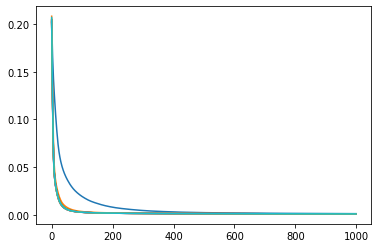

In [ ]:
list_latent_values = []
list_loss = []
for _ in range(10):   
    latent_values, loss = optimize_coding(real_coding)
    @tf.function
    def opt_step(latent_values, real_coding):
        with tf.GradientTape() as tape:
            tape.watch(latent_values)
            gen_output = decoder(latent_values, training=False) 
            loss = mse_loss(real_coding, gen_output[0,:ntimes-1,:,0])   

        gradient = tape.gradient(loss, latent_values)  
        optimizer.apply_gradients(zip([gradient], [latent_values]))  
        
        return loss
    list_latent_values.append(latent_values)
    list_loss.append(loss)

In [ ]:
latent_values = list_latent_values[np.argmin(list_loss)]

In [ ]:
# print(latent_values)

In [ ]:
X_generated = decoder.predict(tf.convert_to_tensor(latent_values)).reshape(ntimes,codings_size)

In [ ]:
# print(scaler.inverse_transform(X_generated))

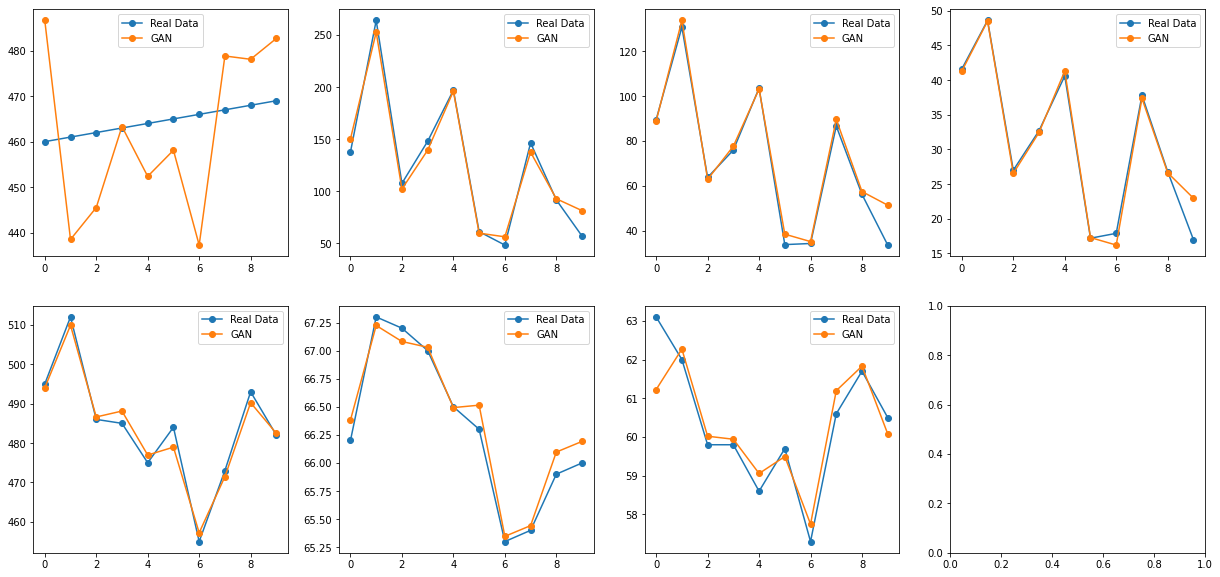

In [ ]:
fig, ax = plt.subplots(2,4, figsize=[21,10])
for i in range(7):
    ax.flatten()[i].plot(scaler.inverse_transform(X_train_concat[n].reshape(-1,codings_size))[:,i], '-o')
    ax.flatten()[i].plot(scaler.inverse_transform(X_generated)[:,i], '-o')
    ax.flatten()[i].legend(['Real Data','GAN'])

## Predict mutiple points

In [ ]:
X_predict_list = []

In [ ]:
optimizer = tf.keras.optimizers.Adam(1e-2)

def mse_loss(inp, outp):
    inp = tf.reshape(inp, [-1, codings_size])
    outp = tf.reshape(outp, [-1, codings_size])
    return tf.reduce_mean(tf.math.squared_difference(inp, outp))

In [ ]:
@tf.function
def opt_step(latent_values, real_coding):
    with tf.GradientTape() as tape:
        tape.watch(latent_values)
        gen_output = decoder(latent_values, training=False) 
        loss = mse_loss(real_coding, gen_output[0,:ntimes-1,:,0])   

    gradient = tape.gradient(loss, latent_values)  
    optimizer.apply_gradients(zip([gradient], [latent_values]))  
    
    return loss

In [ ]:
def optimize_coding(real_coding):
    latent_values = tf.random.normal([1, latent_space], mean=0.0, stddev=0.01)  
    latent_values = tf.Variable(latent_values)     #make input a tensorflow variable so it can be trained
    
    loss = []
    for epoch in range(1000):
        loss.append(opt_step(latent_values, real_coding).numpy())
        
    plt.plot(loss)
    #plt.grid()
    plt.show
        
    return latent_values, loss[-1]

In [ ]:
n = 450
real_coding = X_train_concat[n,:ntimes-1,:]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)
print(real_coding.shape)

(9, 7)


In [ ]:
temp_real_coding = real_coding

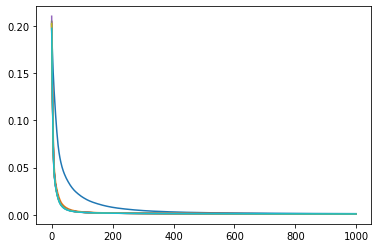

In [ ]:
list_latent_values = []
list_loss = []
for _ in range(10):   
    latent_values, loss = optimize_coding(real_coding)
    @tf.function
    def opt_step(latent_values, real_coding):
        with tf.GradientTape() as tape:
            tape.watch(latent_values)
            gen_output = decoder(latent_values, training=False) 
            loss = mse_loss(real_coding, gen_output[0,:ntimes-1,:,0])   

        gradient = tape.gradient(loss, latent_values)  
        optimizer.apply_gradients(zip([gradient], [latent_values]))  
        
        return loss
    list_latent_values.append(latent_values)
    list_loss.append(loss)

In [ ]:
latent_values = list_latent_values[np.argmin(list_loss)]

In [ ]:
X_generated = decoder.predict(tf.convert_to_tensor(latent_values)).reshape(ntimes,codings_size)

In [ ]:
X_predict = X_generated[-1,:]

In [ ]:
X_predict_list.append(X_predict)

In [ ]:
real_coding = np.concatenate((real_coding, X_predict.reshape(1,-1)), axis=0)

In [ ]:
print(real_coding.shape)

(10, 7)


In [ ]:
real_coding = real_coding[1:,:]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)
print(real_coding.shape)

(9, 7)


In [ ]:
time = 50

[0.0012366838, 0.0010079389, 0.001006304, 0.0009860834, 0.0010069663, 0.0009813479, 0.000981449, 0.00098097, 0.0009700883, 0.0009715527]
Loss iteration 1: 0.00042389848 - 
Loss iteration 2: 0.0008280542 - 
Loss iteration 3: 0.00057124835 - 
Loss iteration 4: 0.0008374367 - 
Loss iteration 5: 0.0008653764 - 
Loss iteration 6: 0.00084487046 - 
Loss iteration 7: 0.00059830514 - 
Loss iteration 8: 0.0005091263 - 
Loss iteration 9: 0.0005644259 - 
Loss iteration 10: 0.00053965533 - 
Loss iteration 11: 0.00033372527 - 
Loss iteration 12: 0.00056720624 - 
Loss iteration 13: 0.0002830542 - 
Loss iteration 14: 0.00045180364 - 
Loss iteration 15: 0.00041263676 - 
Loss iteration 16: 0.0003631327 - 
Loss iteration 17: 0.00059425074 - 
Loss iteration 18: 0.00047169544 - 
Loss iteration 19: 0.00029928514 - 
Loss iteration 20: 0.00043667178 - 
Loss iteration 21: 0.0003051498 - 
Loss iteration 22: 0.00036191999 - 
Loss iteration 23: 0.00062473543 - 
Loss iteration 24: 0.00042983837 - 
Loss iteration 2

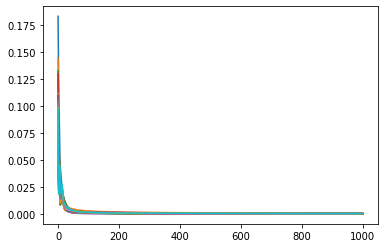

In [ ]:
print(list_loss)

for i in range(time):

    latent_values, loss = optimize_coding(real_coding)

    @tf.function
    def opt_step(latent_values, real_coding):
        with tf.GradientTape() as tape:
            tape.watch(latent_values)
            gen_output = decoder(latent_values, training=False) 
            loss = mse_loss(real_coding, gen_output[0,:ntimes-1,:,0])   

        gradient = tape.gradient(loss, latent_values)  
        optimizer.apply_gradients(zip([gradient], [latent_values]))  
        
        return loss

    print('Loss iteration '+str(i+1)+': '+str(loss), end=' - ')
    print()

    X_generated = decoder.predict(tf.convert_to_tensor(latent_values)).reshape(ntimes,codings_size)

    X_predict = X_generated[-1,:]
    X_predict_list.append(X_predict)
    real_coding = np.concatenate((real_coding, X_predict.reshape(1,-1)), axis=0) 
    real_coding = real_coding[1:,:]
    real_coding = tf.constant(real_coding)
    real_coding = tf.cast(real_coding, dtype=tf.float32)

In [ ]:
X_generated = scaler.inverse_transform(X_predict_list)
X_generated = X_generated.reshape(len(X_predict_list), -1)
X_generated = np.concatenate((scaler.inverse_transform(temp_real_coding), X_generated))
print(X_generated.shape)

(60, 7)


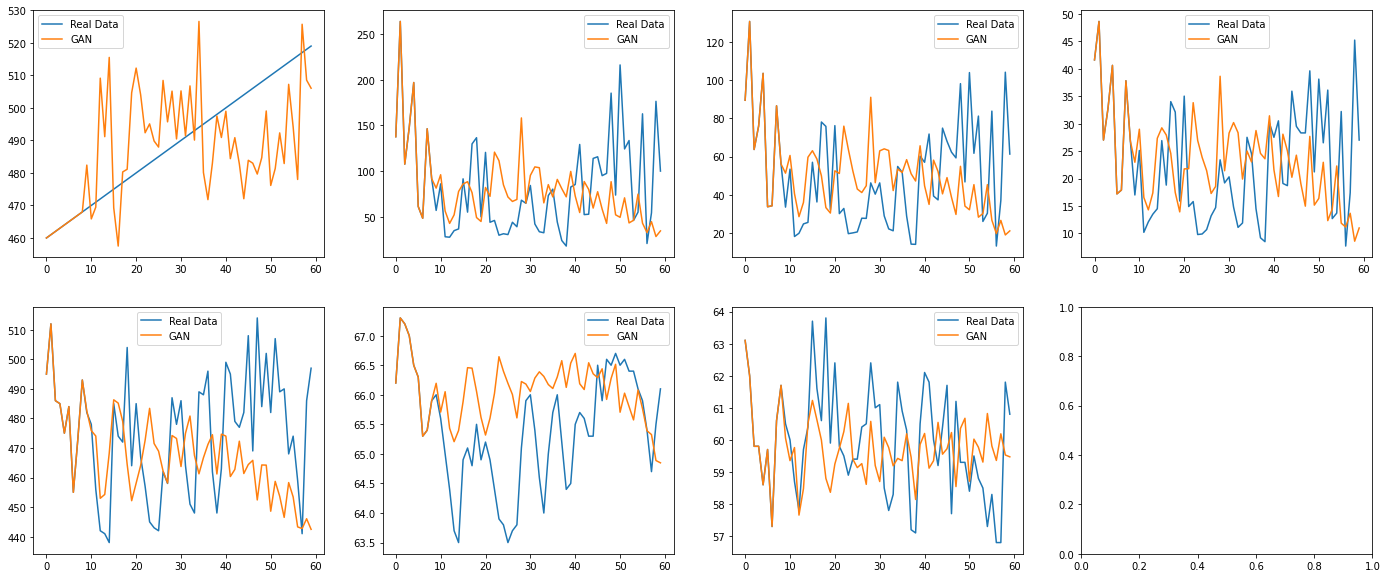

In [ ]:
fig, ax = plt.subplots(2,4, figsize=[24,10])
for i in range(7):
    ax.flatten()[i].plot(scaler.inverse_transform(X_train_concat[n:n+time+10:10].reshape(-1,codings_size))[:,i])
    ax.flatten()[i].plot(X_generated[:,i])
    ax.flatten()[i].legend(['Real Data','GAN'])

# Prediction in time (aae)

## predict one point

In [ ]:
n = 450
real_coding = X_train_concat[n,:ntimes,:]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)
print(real_coding.shape)
print(real_coding)

(10, 7)
tf.Tensor(
[[-0.36530325 -0.28111354 -0.11574557  0.19508448  0.03797468  0.05617978
   0.55617976]
 [-0.3638928   0.4088428   0.31491137  0.41013825  0.25316456  0.30337077
   0.49438202]
 [-0.36248237 -0.44541484 -0.38477582 -0.25345623 -0.07594936  0.28089887
   0.37078652]
 [-0.36107194 -0.22489083 -0.25755996 -0.07834101 -0.08860759  0.23595506
   0.37078652]
 [-0.3596615   0.04312227  0.03128259  0.16436252 -0.21518987  0.12359551
   0.30337077]
 [-0.35825107 -0.69868994 -0.6976017  -0.5545315  -0.10126583  0.07865169
   0.36516854]
 [-0.3568406  -0.7691048  -0.6923879  -0.5330261  -0.46835443 -0.14606741
   0.23033708]
 [-0.3554302  -0.23362446 -0.1459854   0.07834101 -0.24050634 -0.12359551
   0.41573033]
 [-0.35401973 -0.5322052  -0.46402502 -0.2596006   0.01265823 -0.01123596
   0.4775281 ]
 [-0.3526093  -0.7221616  -0.6996872  -0.56067586 -0.12658228  0.01123596
   0.41011235]], shape=(10, 7), dtype=float32)


In [ ]:
X_estimate = np.zeros((ntimes, codings_size))
for i in range(ntimes-1):
    X_estimate[i,:] = real_coding[i,:]
X_estimate[-1,:] = X_estimate[-2,:]
print(X_estimate.shape)
print(X_estimate)

(10, 7)
[[-0.36530325 -0.28111354 -0.11574557  0.19508448  0.03797468  0.05617978
   0.55617976]
 [-0.36389279  0.4088428   0.31491137  0.41013825  0.25316456  0.30337077
   0.49438202]
 [-0.36248237 -0.44541484 -0.38477582 -0.25345623 -0.07594936  0.28089887
   0.37078652]
 [-0.36107194 -0.22489083 -0.25755996 -0.07834101 -0.08860759  0.23595506
   0.37078652]
 [-0.35966149  0.04312227  0.03128259  0.16436252 -0.21518987  0.12359551
   0.30337077]
 [-0.35825107 -0.69868994 -0.69760168 -0.55453151 -0.10126583  0.07865169
   0.36516854]
 [-0.35684061 -0.76910478 -0.69238788 -0.5330261  -0.46835443 -0.14606741
   0.23033708]
 [-0.35543019 -0.23362446 -0.14598539  0.07834101 -0.24050634 -0.12359551
   0.41573033]
 [-0.35401973 -0.53220522 -0.46402502 -0.25960061  0.01265823 -0.01123596
   0.4775281 ]
 [-0.35401973 -0.53220522 -0.46402502 -0.25960061  0.01265823 -0.01123596
   0.4775281 ]]


In [ ]:
def mse_loss(inp, outp):
    return tf.reduce_mean(tf.math.squared_difference(inp[:,-1,:,:], outp[:,-1,:,:]))

In [ ]:
loss_list = []
loss = mse_loss(X_estimate.reshape(1,-1,codings_size,1), tf.reshape(real_coding,[1,-1,codings_size,1]))
loss_list.append(loss)

In [ ]:
X_estimate = X_estimate.reshape(1,ntimes,codings_size,1)

In [ ]:
for i in range(10):
    temp = X_estimate
    X_estimate = decoder.predict(encoder(temp))
    X_estimate[:,:-1,:,:] = temp[:,:-1,:,:]
    loss = mse_loss(X_estimate, tf.reshape(real_coding,[1,ntimes,codings_size,1]))
    loss_list.append(loss)

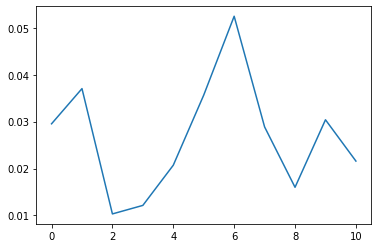

In [ ]:
plt.plot(loss_list)

In [ ]:
print(X_estimate.shape)

(1, 10, 7, 1)


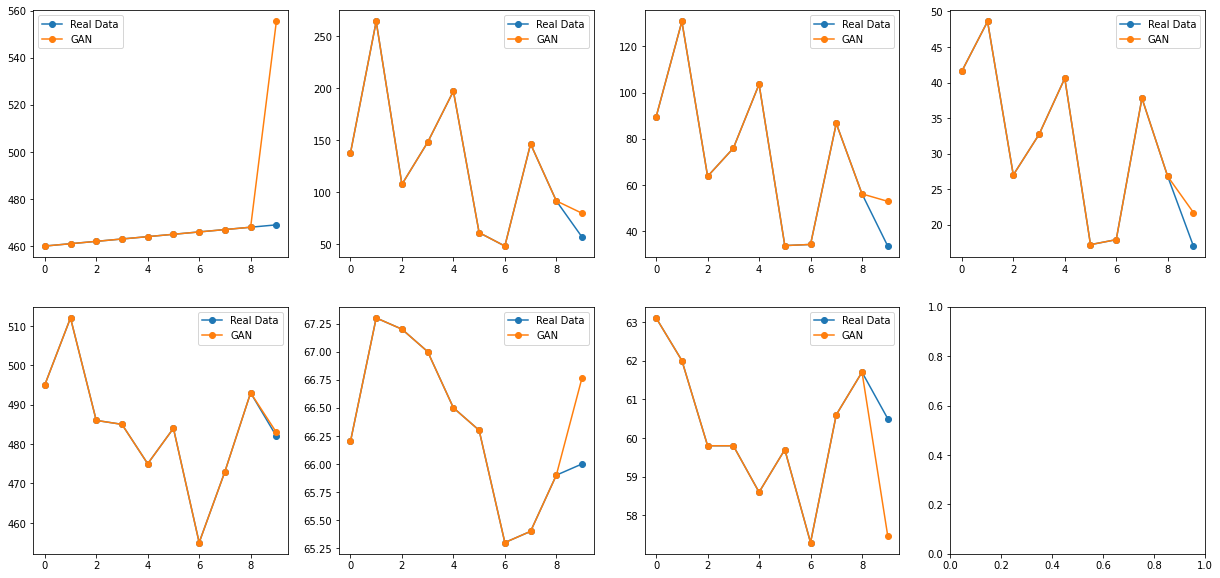

In [ ]:
fig, ax = plt.subplots(2,4, figsize=[21,10])
for i in range(7):
    ax.flatten()[i].plot(scaler.inverse_transform(X_train_concat[n].reshape(-1,codings_size))[:,i], '-o')
    ax.flatten()[i].plot(scaler.inverse_transform(X_estimate.reshape(-1,codings_size))[:,i], '-o')
    ax.flatten()[i].legend(['Real Data','GAN'])

## predict multiple points

In [ ]:
X_predict_list = []

In [ ]:
def mse_loss(inp, outp):
    return tf.reduce_mean(tf.math.squared_difference(inp[:,-1,:,:], outp[:,-1,:,:]))

In [ ]:
n = 450
real_coding = X_train_concat[n,:ntimes,:]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)
print(real_coding.shape)

(10, 7)


In [ ]:
X_estimate = np.zeros((ntimes, codings_size))
for i in range(ntimes-1):
    X_estimate[i,:] = real_coding[i,:]
X_estimate[-1,:] = X_estimate[-2,:]
print(X_estimate.shape)

(10, 7)


In [ ]:
X_estimate = X_estimate.reshape(1,ntimes,codings_size,1)

In [ ]:
time = 200

In [ ]:
for i in range(time):
    for i in range(10):
        temp = X_estimate
        X_estimate = decoder.predict(encoder(temp))
        X_estimate[:,:-1,:,:] = temp[:,:-1,:,:] 
    X_predict_list.append(X_estimate[:,-1,:,:].flatten()) 
    if i != time - 1:
        for j in range(ntimes-1):
            X_estimate[:,j,:,:] = X_estimate[:,j+1,:,:]
        X_estimate[:,-1,:,:] = X_estimate[:,-2,:,:]


In [ ]:
X_generated = scaler.inverse_transform(X_predict_list)
X_generated = X_generated.reshape(len(X_predict_list), -1)
X_generated = np.concatenate((scaler.inverse_transform(real_coding[:ntimes-1,:]), X_generated))
print(X_generated.shape)

(59, 7)


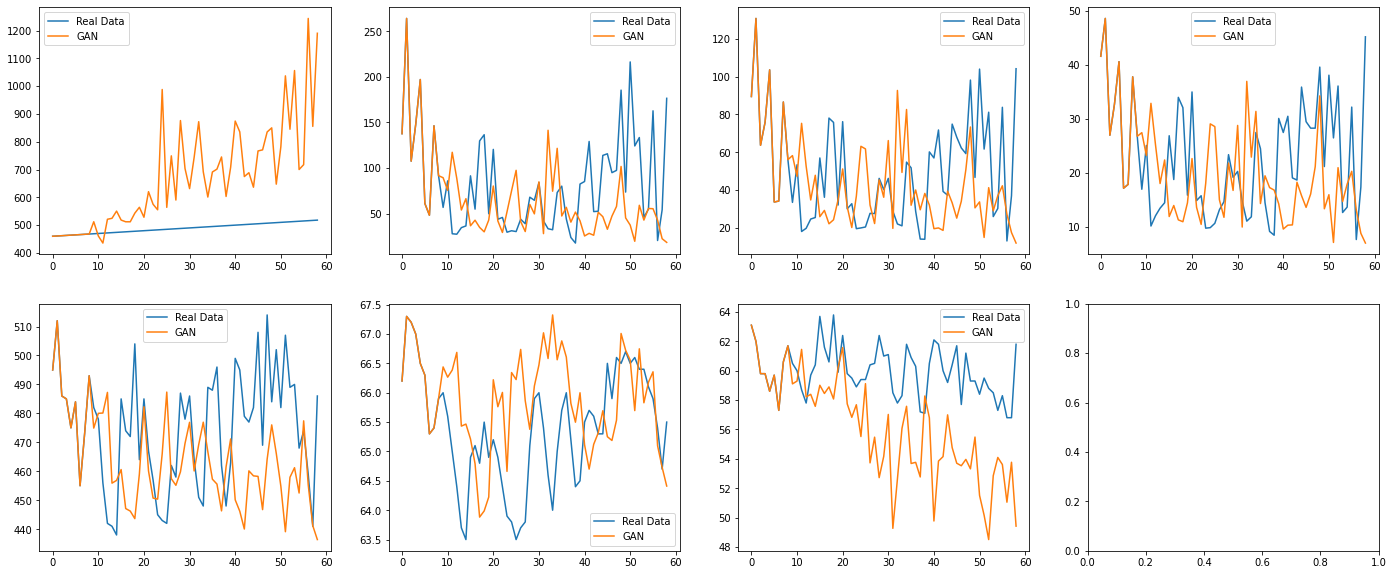

In [ ]:
fig, ax = plt.subplots(2,4, figsize=[24,10])
for i in range(7):
    ax.flatten()[i].plot(X_train[n:n+ntimes+time-1].reshape(-1,codings_size)[:,i])
    ax.flatten()[i].plot(X_generated[:,i])
    ax.flatten()[i].legend(['Real Data','GAN'])

# use pm10 predict others

In [ ]:
n = 450
real_coding = X_train_concat[n,:ntimes,:]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)
print(real_coding.shape)

(10, 7)


In [ ]:
X_estimate = np.zeros((ntimes, codings_size))
X_estimate[0,:] = real_coding[0,:]
X_estimate[1,:] = real_coding[1,:]
X_estimate[2,:] = real_coding[1,:] /2
X_estimate[3,:] = real_coding[1,:] /5
print(X_estimate)

[[-0.36530325 -0.28111354 -0.11574557  0.19508448  0.03797468  0.05617978
   0.55617976]
 [-0.36389279  0.4088428   0.31491137  0.41013825  0.25316456  0.30337077
   0.49438202]
 [-0.1819464   0.2044214   0.15745568  0.20506912  0.12658228  0.15168539
   0.24719101]
 [-0.07277856  0.08176856  0.06298228  0.08202765  0.05063291  0.06067415
   0.0988764 ]
 [ 0.          0.          0.          0.          0.          0.
   0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.        ]]


In [ ]:
def mse_loss(inp, outp):
    return tf.reduce_mean(tf.math.squared_difference(inp[:,-1,:,:], outp[:,-1,:,:]))

In [ ]:
loss_list = []
loss = mse_loss(X_estimate.reshape(1,-1,codings_size,1), tf.reshape(real_coding,[1,-1,codings_size,1]))
loss_list.append(loss)

In [ ]:
X_estimate = X_estimate.reshape(1,ntimes,codings_size,1)

In [ ]:
for i in range(10):
    temp = X_estimate
    X_estimate = decoder.predict(encoder(temp))
    # X_estimate[:,:-1,:,:] = temp[:,:-1,:,:]
    loss = mse_loss(X_estimate, tf.reshape(real_coding,[1,ntimes,codings_size,1]))
    loss_list.append(loss)

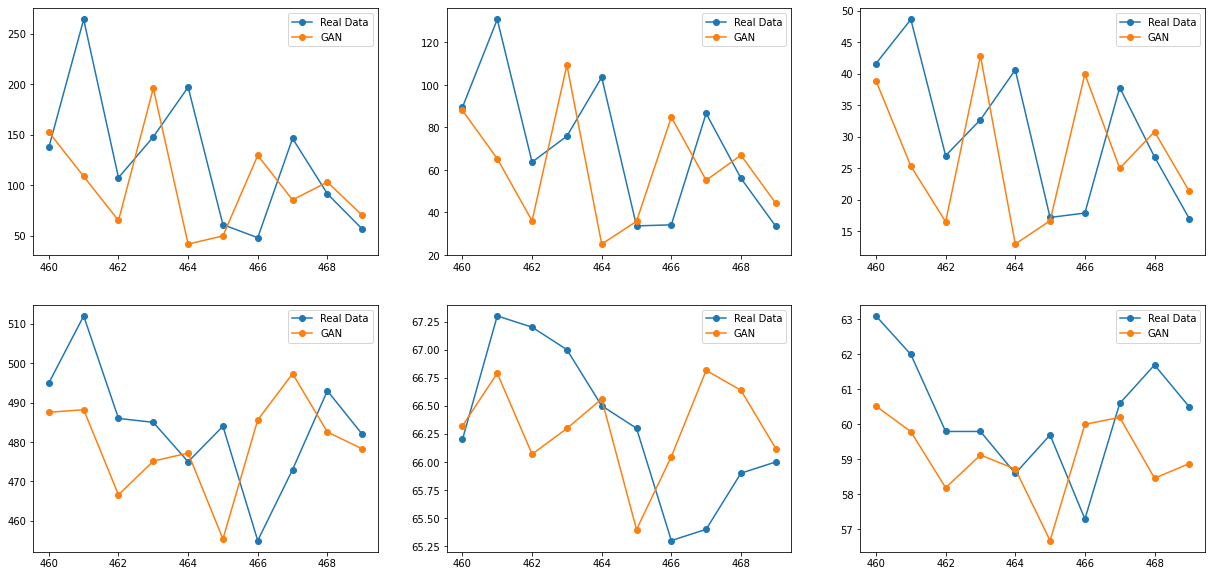

In [ ]:
fig, ax = plt.subplots(2,3, figsize=[21,10])
for i in range(6):
    # if (i ==0):
    #     ax.flatten()[i].plot(scaler.inverse_transform(X_train_concat[n].reshape(-1,codings_size))[:,0], scaler.inverse_transform(X_train_concat[n].reshape(-1,codings_size))[:,i+1], '-o')
    #     ax.flatten()[i].plot(scaler.inverse_transform(X_train_concat[n].reshape(-1,codings_size))[:,0], scaler.inverse_transform(X_train_concat[n].reshape(-1,codings_size))[:,i+1], '-o')
    #     ax.flatten()[i].legend(['Real Data','GAN'])
    # else:
        ax.flatten()[i].plot(scaler.inverse_transform(X_train_concat[n].reshape(-1,codings_size))[:,0], scaler.inverse_transform(X_train_concat[n].reshape(-1,codings_size))[:,i+1], '-o')
        ax.flatten()[i].plot(scaler.inverse_transform(X_train_concat[n].reshape(-1,codings_size))[:,0], scaler.inverse_transform(X_estimate.reshape(-1,codings_size))[:,i+1], '-o')
        ax.flatten()[i].legend(['Real Data','GAN'])

# Correlation analysis

## Entire day

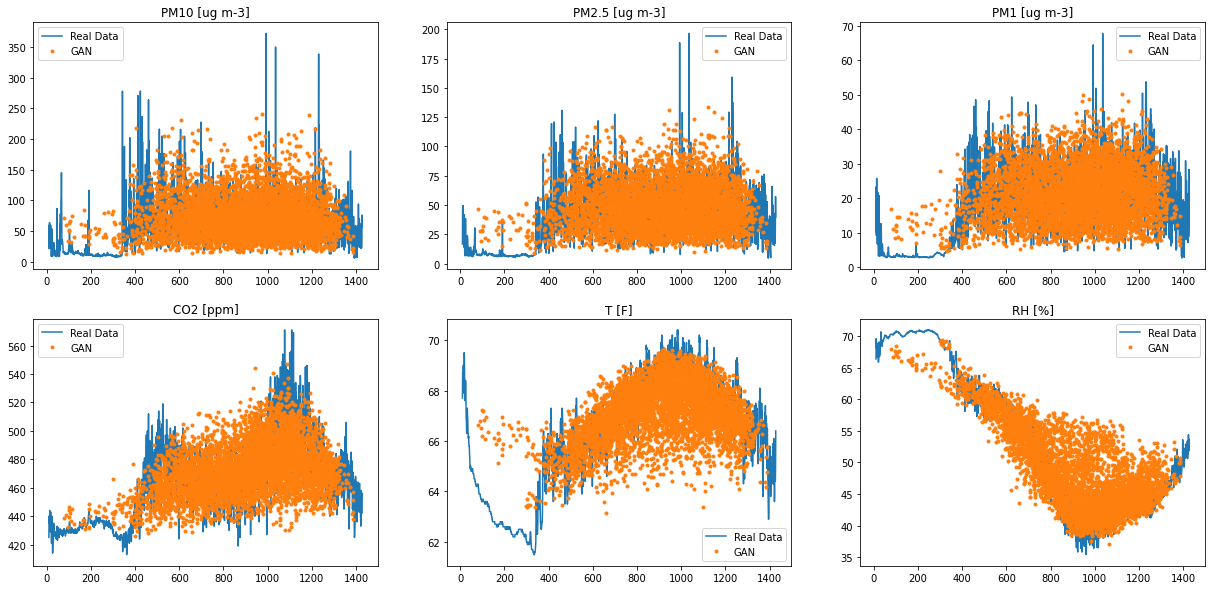

In [ ]:
num_examples_to_generate = 500

seed = tf.random.normal([num_examples_to_generate, latent_space])
X_generated = scaler.inverse_transform(decoder.predict(seed).reshape(num_examples_to_generate*ntimes,codings_size))

columnIndex = 0
# Sort 2D numpy array by 1st Column
X_generated = X_generated[X_generated[:,columnIndex].argsort()]

fig, ax = plt.subplots(2,3, figsize=[21,10])
for i in range(6):
    ax.flatten()[i].plot(X_train[:,0], X_train[:,i+1])
    ax.flatten()[i].plot(X_generated[:,0], X_generated[:,i+1], '.')
    ax.flatten()[i].legend(['Real Data','GAN'])
    ax.flatten()[i].set_title(group[i])

In [ ]:
print(X_generated.shape)

(5000, 7)


In [ ]:
start_time = 810
time = 30
end_time = start_time + time - 1

In [ ]:
field_list = []
for i in range(len(X_generated)):
    if (X_generated[i,0] >= start_time and X_generated[i,0] <= end_time):
        field_list.append(X_generated[i,:])

In [ ]:
field_list = np.concatenate(field_list)
field_list = field_list.reshape(-1, codings_size)
print(field_list.shape)

(169, 7)


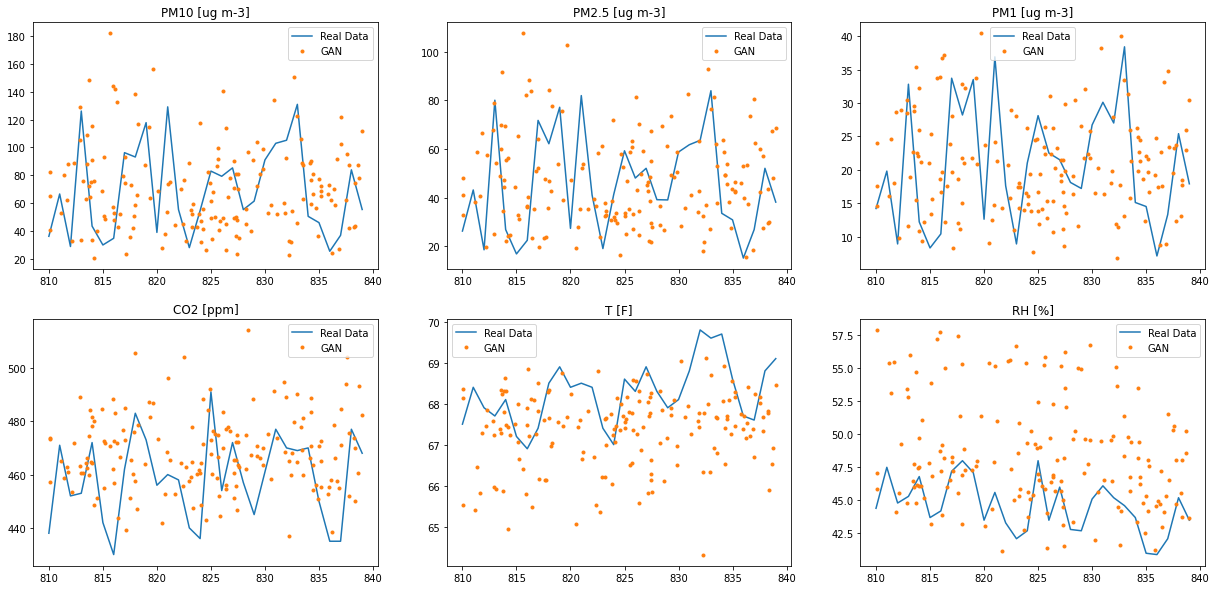

In [ ]:
fig, ax = plt.subplots(2,3, figsize=[21,10])
for i in range(6):
    ax.flatten()[i].plot(X_train[start_time-10:end_time-9:1,0], X_train[start_time:end_time+1:1,i+1],'-')
    ax.flatten()[i].plot(field_list[:,0], field_list[:,i+1], '.')
    ax.flatten()[i].legend(['Real Data','GAN'])
    ax.flatten()[i].set_title(group[i])

In [ ]:
corr = np.corrcoef(X_train[:,1:], rowvar=False)
print(corr)

[[ 1.          0.96316754  0.90622649  0.59011331  0.5248146  -0.36173622]
 [ 0.96316754  1.          0.98203463  0.67218996  0.60735889 -0.46647001]
 [ 0.90622649  0.98203463  1.          0.71674477  0.6429727  -0.52321419]
 [ 0.59011331  0.67218996  0.71674477  1.          0.72120761 -0.62551043]
 [ 0.5248146   0.60735889  0.6429727   0.72120761  1.         -0.83940183]
 [-0.36173622 -0.46647001 -0.52321419 -0.62551043 -0.83940183  1.        ]]


In [ ]:
corr = np.corrcoef(X_generated[:,1:], rowvar=False)
print(corr)

[[ 1.          0.95013117  0.91079017  0.45089426  0.3089345   0.02109243]
 [ 0.95013117  1.          0.96073105  0.48100244  0.32459333 -0.01881271]
 [ 0.91079017  0.96073105  1.          0.5444465   0.38936614 -0.09284628]
 [ 0.45089426  0.48100244  0.5444465   1.          0.66097816 -0.43448404]
 [ 0.3089345   0.32459333  0.38936614  0.66097816  1.         -0.70383244]
 [ 0.02109243 -0.01881271 -0.09284628 -0.43448404 -0.70383244  1.        ]]


## Time Period

In [ ]:
corr = np.corrcoef(X_train[start_time-10:end_time-9:1,1:], rowvar=False)
print(corr)

[[1.         0.98841849 0.97013917 0.56162783 0.47301721 0.57649409]
 [0.98841849 1.         0.98989053 0.55899938 0.43076398 0.56918117]
 [0.97013917 0.98989053 1.         0.55423051 0.39995507 0.58448562]
 [0.56162783 0.55899938 0.55423051 1.         0.69774363 0.83549732]
 [0.47301721 0.43076398 0.39995507 0.69774363 1.         0.44717747]
 [0.57649409 0.56918117 0.58448562 0.83549732 0.44717747 1.        ]]


In [ ]:
corr = np.corrcoef(field_list[:,1:], rowvar=False)
print(corr)

[[ 1.          0.96575909  0.93209905  0.50293373  0.25502309  0.1774589 ]
 [ 0.96575909  1.          0.95775463  0.50660519  0.21670264  0.18895776]
 [ 0.93209905  0.95775463  1.          0.54129726  0.29493618  0.11270302]
 [ 0.50293373  0.50660519  0.54129726  1.          0.38104879  0.11139504]
 [ 0.25502309  0.21670264  0.29493618  0.38104879  1.         -0.6697082 ]
 [ 0.1774589   0.18895776  0.11270302  0.11139504 -0.6697082   1.        ]]


(array([-50, -49, -48, -47, -46, -45, -44, -43, -42, -41, -40, -39, -38,
        -37, -36, -35, -34, -33, -32, -31, -30, -29, -28, -27, -26, -25,
        -24, -23, -22, -21, -20, -19, -18, -17, -16, -15, -14, -13, -12,
        -11, -10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,
          2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
         15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
         41,  42,  43,  44,  45,  46,  47,  48,  49,  50]),
 array([0.5437334 , 0.56430274, 0.54526794, 0.56314516, 0.5416075 ,
        0.5350417 , 0.5625658 , 0.5571153 , 0.5652041 , 0.59662163,
        0.59656435, 0.5959991 , 0.58614564, 0.61527026, 0.5826095 ,
        0.6005187 , 0.592507  , 0.5823501 , 0.6023098 , 0.61548835,
        0.6239063 , 0.6294631 , 0.6359703 , 0.62468964, 0.6670915 ,
        0.63190615, 0.6696581 , 0.62918913, 0.6614299 , 0.64684963,
        0.6372386 , 0

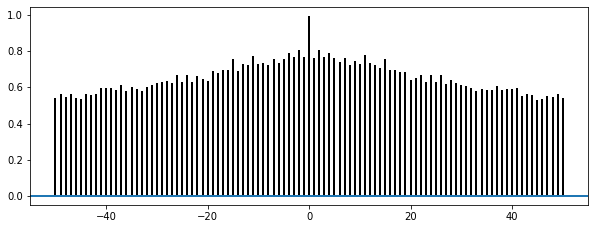

In [ ]:
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(211)
 
x = field_list[:,1].flatten()
y = field_list[:,2].flatten()

ax1.xcorr(x, y, usevlines=True, maxlags=50, normed=True, lw=2)